In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import os

In [21]:
images = []
labels = []

valid_ext = (".jpg", ".jpeg", ".png")

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)

    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):

            # Skip non-image files
            if not img_name.lower().endswith(valid_ext):
                continue

            img_path = os.path.join(class_path, img_name)

            img = cv2.imread(img_path)

            if img is None:
                print("Skipped:", img_path)
                continue

            img = cv2.resize(img, img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            images.append(img.flatten())
            labels.append(class_name)
print("Total images loaded:", len(images))
print("Unique labels:", set(labels))



Total images loaded: 298
Unique labels: {'Smartphone', 'PC', 'Laptop'}


In [22]:
import numpy as np

# images & labels already filled by your loop
X = np.array(images, dtype=np.float32)

# normalize pixels (0–1)
X = X / 255.0

print("X shape:", X.shape)
print("Number of samples:", len(X))
print("Example labels:", labels[:5])


X shape: (298, 16384)
Number of samples: 298
Example labels: ['Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop']


In [ ]:
# Assuming we have 3 device types: Laptop, PC, Smartphone
k = 3  # Laptop, PC, Smartphone
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)

clusters = kmeans.fit_predict(X)

print("First 10 cluster labels:", clusters[:10])


First 10 cluster labels: [1 2 2 1 2 2 2 1 1 0]


In [ ]:
# Create a DataFrame to compare actual labels with cluster assignments
unique, counts = np.unique(clusters, return_counts=True)
for c, n in zip(unique, counts):
    print(f"Cluster {c}: {n} images")


Cluster 0: 96 images
Cluster 1: 88 images
Cluster 2: 114 images


In [ ]:
# Create a DataFrame to compare actual labels with cluster assignments
df = pd.DataFrame({
    "actual_label": labels,
    "cluster": clusters
})

crosstab = pd.crosstab(df["actual_label"], df["cluster"])
print(crosstab)


cluster        0   1   2
actual_label            
Laptop        35  27  52
PC            27  52   8
Smartphone    34   9  54


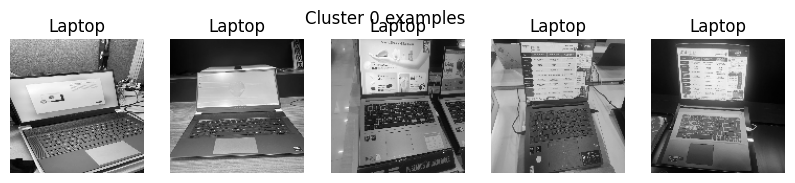

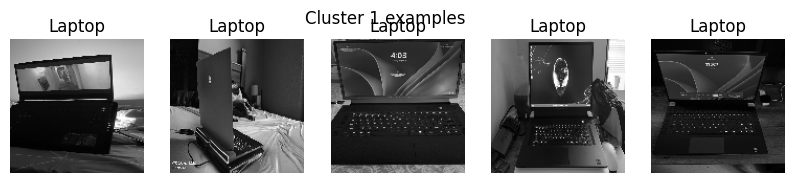

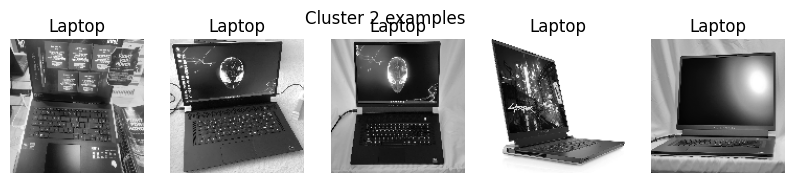

In [ ]:
# Visualize some examples from each cluster
import matplotlib.pyplot as plt

img_size = (128, 128)  # same as before

def show_examples_for_cluster(cluster_id, n=5):
    idxs = np.where(clusters == cluster_id)[0][:n]
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(idxs):
        img = X[idx].reshape(img_size)
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(labels[idx])
    plt.suptitle(f"Cluster {cluster_id} examples")
    plt.show()

for c in range(k):
    show_examples_for_cluster(c, n=5)


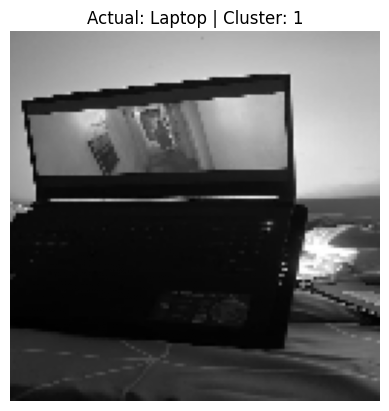

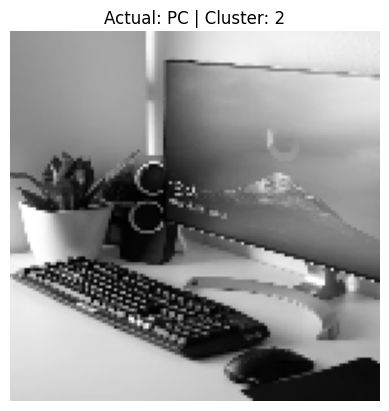

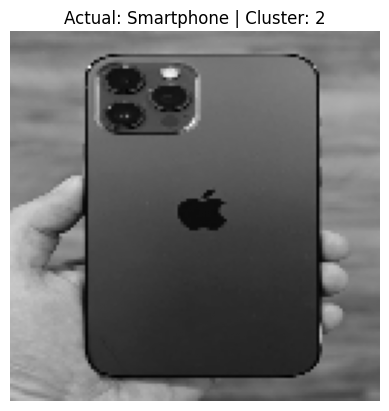

In [ ]:
# Show one representative image from each actual class with its cluster assignment
classes = sorted(list(set(labels)))  # ['Laptop', 'PC', 'Smartphone']
representative_indices = {}

for cls in classes:
    for i, lbl in enumerate(labels):
        if lbl == cls:
            representative_indices[cls] = i
            break

for cls, idx in representative_indices.items():
    img = X[idx].reshape(img_size)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"Actual: {cls} | Cluster: {clusters[idx]}")
    plt.show()


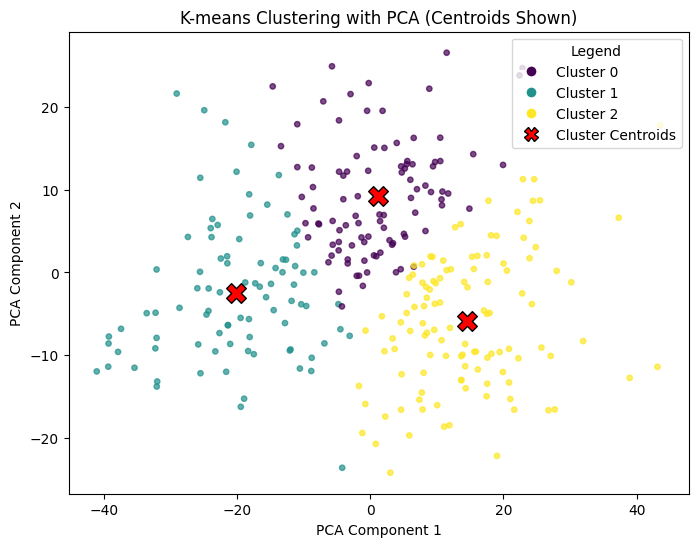

In [48]:
# PCA transformation
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X)

centroids = kmeans.cluster_centers_
centroids_2d = pca.transform(centroids)

plt.figure(figsize=(8,6))

# Scatter plot of data points colored by cluster
scatter = plt.scatter(
    X_2d[:,0], X_2d[:,1],
    c=clusters,
    cmap='viridis',
    s=15,
    alpha=0.7
)

# Centroids (red X)
plt.scatter(
    centroids_2d[:,0], centroids_2d[:,1],
    marker='X',
    s=200,
    color='red',
    edgecolors='black'
)

# ---- CLEAN LEGEND ----
legend_elements = [
    Line2D([0],[0], marker='o', color='w', label='Cluster 0',
           markerfacecolor=scatter.cmap(scatter.norm(0)), markersize=8),
    Line2D([0],[0], marker='o', color='w', label='Cluster 1',
           markerfacecolor=scatter.cmap(scatter.norm(1)), markersize=8),
    Line2D([0],[0], marker='o', color='w', label='Cluster 2',
           markerfacecolor=scatter.cmap(scatter.norm(2)), markersize=8),
    Line2D([0],[0], marker='X', color='w', label='Cluster Centroids',
           markerfacecolor='red', markeredgecolor='black', markersize=10)
]

plt.legend(handles=legend_elements, title="Legend")

plt.title("K-means Clustering with PCA (Centroids Shown)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [49]:
sil_score = silhouette_score(X, clusters)
print("Silhouette score:", sil_score)


Silhouette score: 0.10279948264360428


In [50]:
def kmeans_with_history(X, k=3, max_iters=20, random_state=42):
    rng = np.random.RandomState(random_state)
    
    # 1) random init: pick k random points as initial centroids
    init_idx = rng.choice(len(X), size=k, replace=False)
    centroids = X[init_idx].copy()
    
    inertias = []             # objective value per iteration
    centroids_history = [centroids.copy()]  # keep track of positions

    for it in range(max_iters):
        # 2) assign each point to nearest centroid
        # distances: (n_samples, k)
        dists = np.linalg.norm(X[:, None, :] - centroids[None, :, :], axis=2)
        labels_km = dists.argmin(axis=1)

        # 3) compute objective (sum of squared distances to centroids)
        inertia = np.sum((X - centroids[labels_km])**2)
        inertias.append(inertia)

        # 4) recompute centroids
        new_centroids = []
        for j in range(k):
            cluster_points = X[labels_km == j]
            if len(cluster_points) == 0:
                # if a cluster got empty, re-init it randomly
                new_centroids.append(X[rng.randint(0, len(X))])
            else:
                new_centroids.append(cluster_points.mean(axis=0))
        centroids = np.vstack(new_centroids)

        centroids_history.append(centroids.copy())
    
    return labels_km, centroids, inertias, centroids_history

In [51]:
k = 3
labels_km, centroids_final, inertias, centroids_history = kmeans_with_history(X, k=k, max_iters=20)
print("Iterations run:", len(inertias))

Iterations run: 20
